<a href="https://colab.research.google.com/github/hugo-degrossi/cesi_data_science/blob/main/livrable_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-class image classification using deep learning with Tensorflow & Keras
## Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2

from imgaug import augmenters

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, roc_curve, auc

## Utils

fonction that can be used everywhere


In [3]:
# useful functions

def load_all_images(datasets, img_height, img_width, max_images, base_path):
    X = []
    y = []
    for dataset in datasets:
        images_list = os.listdir(base_path + dataset['path'])
        loaded_images = []
        for idx, image in enumerate(images_list):
            img = tf.keras.preprocessing.image.load_img(
                    base_path + dataset['path'] + '/' + image,
                    target_size=(img_height, img_width),
                    color_mode="grayscale")
            X.append(np.asarray(img))
            y.append(dataset['name'])
            
            if (idx == max_images): break
    return np.array(X), np.array(y)

def plot_five(X):
    f, ax = plt.subplots(1,5)
    f.set_size_inches(80, 40)
    for i in range(5):
        ax[i].axis('off')
        ax[i].imshow(X[i], cmap='gray')
    plt.show()

def plot_curve(name, x_label, y_label, x, y):
  plt.plot(x)
  plt.plot(y)
  plt.title(name)
  plt.ylabel(x_label)
  plt.xlabel(y_label)
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

def plt_conf(y_test, y_pred, classes):
  n_classes = len(classes)

  fig, ax = plt.subplots(1,n_classes, figsize=(15, 15))
  for i in range(n_classes):
    conf_matrix = confusion_matrix(y_test[:, i], np.rint(y_pred[:, i]))
    ax[i].matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    ax[i].set_title(classes[i])
    for j in range(conf_matrix.shape[0]):
        for k in range(conf_matrix.shape[1]):
            ax[i].text(x=k, y=j,s=conf_matrix[j, k], va='center', ha='center')
            ax[i].set_ylabel('predicted')
            ax[i].set_xlabel('real')

  score = cnn.evaluate(X_test, y_test, verbose = 0)
  print('Test loss:', score[0])
  print('Test accuracy:', score[1])

def roc_curve_plot(fpr, tpr, roc_auc, classes):
  plt.figure()
  lw = 2

  for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], label=f'RF (area = {roc_auc[i]:.3f}) class = {classes[i]}')
  plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Receiver operating characteristic example")
  plt.legend(loc="lower right")
  plt.show()

## Load data
Load the datasets and compile them.

In [4]:
base_path = "/content/drive/MyDrive/livrable_1/"

# all datasets and their labels
datasets = [
    {'name':'schematics', 'path':"Schematics/Schematics"},
    {'name':'sketch', 'path':"Sketch/Sketch"},
    #{'name':'painting', 'path':"Painting/Painting"},
    {'name':'text', 'path':"Text/Text"},
    {'name':'photo', 'path':"Photo/Photo"},
]

# define an image size
img_height = 128
img_width = 128

n_images_per_class = 1000

In [5]:
data, labels = load_all_images(datasets, img_height, img_width, n_images_per_class, base_path)

## Have a look at data

We want to have a first look at the data to be sure it's conform

Number of images X: 4004
Image shape: (128, 128)
Classes: 
photo         1001
schematics    1001
sketch        1001
text          1001
dtype: int64




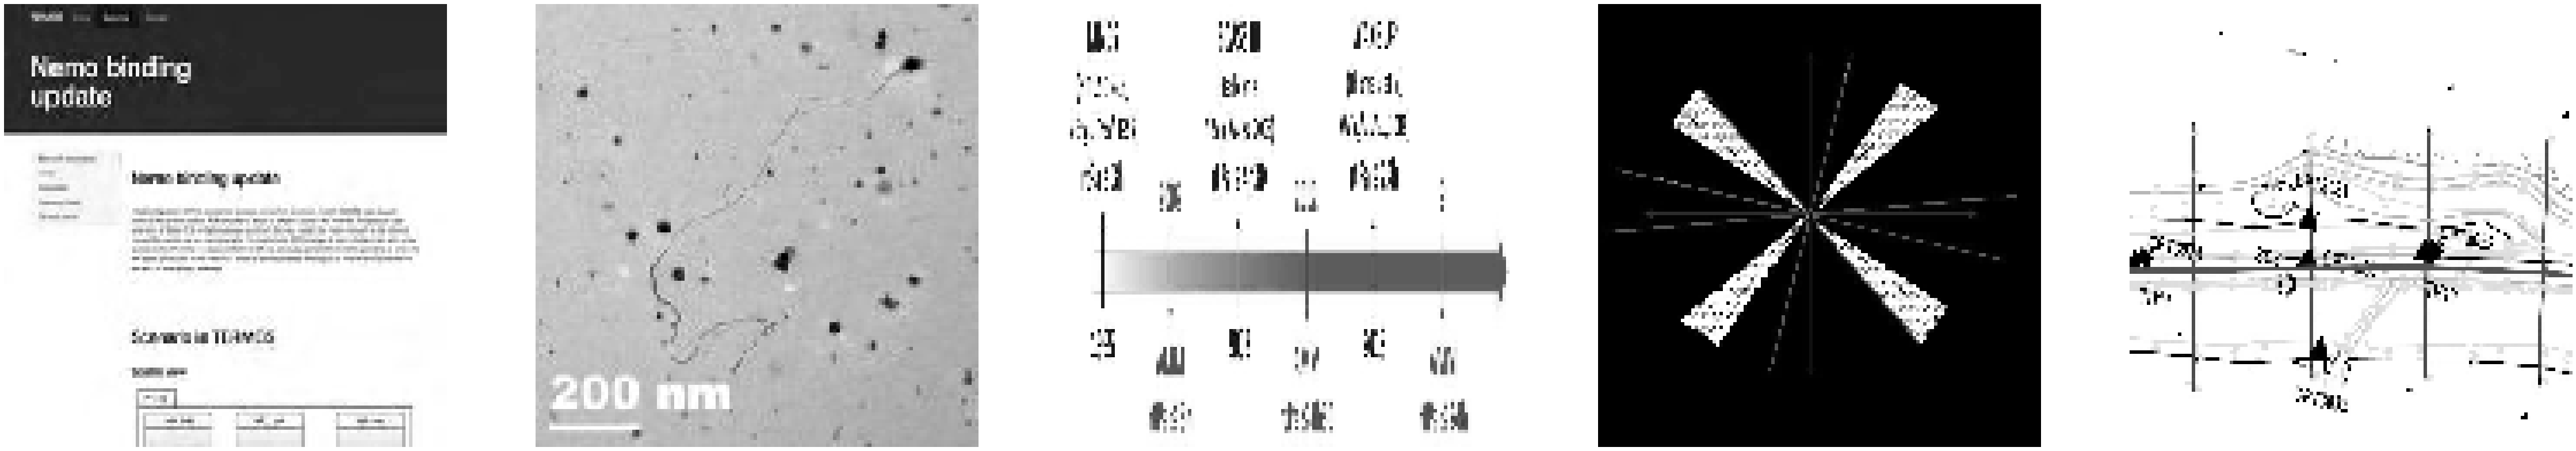

In [6]:
print(f"Number of images X: {len(data)}")
print(f"Image shape: {data[0].shape}")
print(f"Classes: \n{pd.DataFrame(labels).value_counts()}\n\n")
plot_five(data)

as we can see, the data have been formated and is in gray shades as planned.

## Normalize
We want to normalize the data so it's trainable for our deep learning neural network (else it would use too much machine power for less results).

In [7]:
# normalize 
X = [img / 255 for img in data]
y = pd.get_dummies(labels)

In [8]:
classes = list(y.columns)

## Split data

Splitting the data into train, validation and test dataset.
- Train: 72%
- Validation: 8%
- Test: 20%

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_val = X_train[:int(len(X_train) * 0.1)]
y_val = y_train[:int(len(y_train) * 0.1)]

X_train = X_train[int(len(X_train) * 0.1):]
y_train = y_train[int(len(y_train) * 0.1):]

print(f"Number of images X_train: {len(X_train)}, and y_train: {len(y_train)}")
print(f"Number of images X_val: {len(X_val)}, and y_train: {len(y_val)}")
print(f"Number of images X_test: {len(X_test)}, and y_train: {len(y_test)}")

Number of images X_train: 2883, and y_train: 2883
Number of images X_val: 320, and y_train: 320
Number of images X_test: 801, and y_train: 801


## Basic params

Defining basic params to be used afterwards.

In [10]:
batch_size       = 64
epochs           = 75
fit_verbosity    = 1
n_classes        = 4

## Modelling

- We will go for a simple convolution model with relu activation on each convolution layer, decreasing size filter (from (5,5) to (3,3) and (4,4) to (2,2))
- We will use multiple dropout layers to prevent overfitting
- And end the neural network by flattening the last convolution and adding 3 Dense layers where the last one is the output (n_classes).

In [22]:
# inputs
inputs = layers.Input(shape=(img_height,img_width,1))
# convolution with dropout
x = layers.Conv2D(8, (5,5), padding='same', activation="relu")(inputs)
x = layers.MaxPooling2D((4,4))(x)
x = layers.Dropout(.3)(x)
x = layers.Conv2D(16, (3,3), padding='same', activation="relu")(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(.3)(x)
# flatten
x = layers.Flatten()(x)
# dense
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(.3)(x)
# outputs
outputs = layers.Dense(n_classes, activation="softmax")(x)

# creating the model
cnn = Model(inputs, outputs, name='cnn')

# compile
cnn.compile(optimizer = 'adam',
              loss = 'categorical_crossentropy',
              metrics=['accuracy'])

# visualize it
cnn.summary()

Model: "cnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 8)       208       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 32, 32, 8)        0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 32, 32, 8)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 16)        1168      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                           

## Training

We will now train our model, but first we'll convert all the train, val and test sets to numpy array (compatibility and performance issue etherwise).

In [23]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [24]:
history = cnn.fit(
    X_train, y_train,
    validation_data = (X_val, y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=fit_verbosity,
)

Epoch 1/75
46/46 [==============================] - 1s 15ms/step - loss: 1.4544 - accuracy: 0.2882 - val_loss: 1.3191 - val_accuracy: 0.4031
Epoch 2/75
46/46 [==============================] - 0s 10ms/step - loss: 1.0127 - accuracy: 0.5442 - val_loss: 0.7387 - val_accuracy: 0.7500
Epoch 3/75
46/46 [==============================] - 0s 10ms/step - loss: 0.6092 - accuracy: 0.7624 - val_loss: 0.5711 - val_accuracy: 0.8188
Epoch 4/75
46/46 [==============================] - 0s 10ms/step - loss: 0.5010 - accuracy: 0.8016 - val_loss: 0.4985 - val_accuracy: 0.8469
Epoch 5/75
46/46 [==============================] - 0s 10ms/step - loss: 0.4524 - accuracy: 0.8176 - val_loss: 0.4721 - val_accuracy: 0.8156
Epoch 6/75
46/46 [==============================] - 0s 10ms/step - loss: 0.4067 - accuracy: 0.8404 - val_loss: 0.4775 - val_accuracy: 0.8250
Epoch 7/75
46/46 [==============================] - 0s 10ms/step - loss: 0.3997 - accuracy: 0.8470 - val_loss: 0.3886 - val_accuracy: 0.8562
Epoch 8/75
46

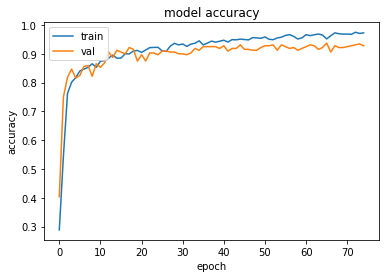

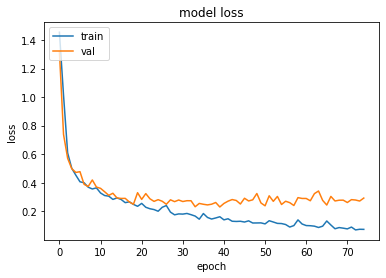

In [25]:
plot_curve('model accuracy', 'accuracy', 'epoch', history.history['accuracy'], history.history['val_accuracy'])
plot_curve('model loss', 'loss', 'epoch', history.history['loss'], history.history['val_loss'])

## Testing

In [26]:
print(f"Number of images X: {len(y_train)}")
print(f"Classes: \n{pd.DataFrame(y_train).value_counts()}\n\n")
print(f"Number of images X: {len(y_test)}")
print(f"Classes: \n{pd.DataFrame(y_test).value_counts()}\n\n")

Number of images X: 2883
Classes: 
0  1  2  3
1  0  0  0    726
0  0  1  0    722
   1  0  0    721
   0  0  1    714
dtype: int64


Number of images X: 801
Classes: 
0  1  2  3
0  0  0  1    208
      1  0    199
   1  0  0    197
1  0  0  0    197
dtype: int64




In [27]:
y_pred = cnn.predict(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

26/26 [==============================] - 0s 3ms/step


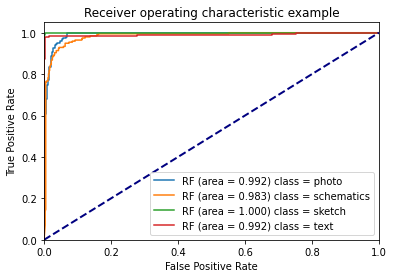

In [28]:
roc_curve_plot(fpr, tpr, roc_auc, classes)

Test loss: 0.21323522925376892
Test accuracy: 0.9463170766830444


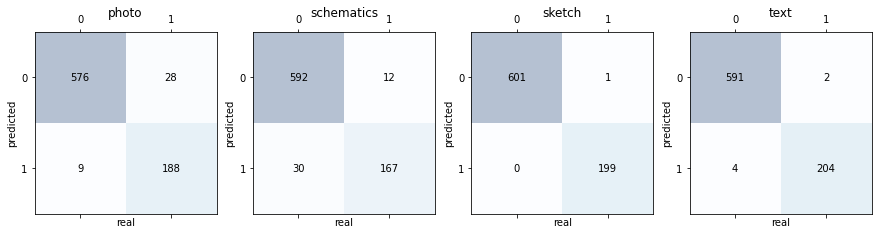

In [29]:
plt_conf(y_test, y_pred, classes)

## save model

In [30]:
pip install pyyaml h5py  # Required to save models in HDF5 format

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
cnn.save('delivrable_1.h5')